In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect
from sqlalchemy import desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Explanation of my approach to completing the first section

* We begin with a sqlite database that contains a few tables of specific interest. For this first part, we want to get information from the Measurement table from the 'date' and 'prcp' columns. First, we a datetime module to create an object that has the specific date we want to use as a reference. (I used an sqlite DB browser to find out what the relevant date would be.) Then, we use SQL alchemy to query this database, and filter by referencing that date. 

* The output for our SQL alchemy query is in list format, with each item containing two pieces of separate information that we want to parse. Thankfully (because of automap), each piece retains its 'date' and 'prcp' identifying tags. So, I use a loop that appends each side of the combined list structure we've created into separate lists (to make sure it's coming out right, I print every 500 results). Then, I mash the two lists together into a dictionary. Finally, I use pd.DataFrame() to turn our new dict into a dataframe, from which I can create the first plot.

* Since there are multiple stations per day, it is necessary to use some sort of method to converge the information by day. I used sum() because it produced a result identical to the objective, but it would actually make more sense to take a median value.

* Once a plot object is created, it can be modified with MatPlotLib even though the plot was not created using MatPlotLib.


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

prev_year_date  = dt.date(2017, 8, 23) - dt.timedelta(days=365)

date_precip_list_for_1_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= prev_year_date).all()


In [12]:
date_list=list()
precip_list=list()
counter=0
for row in date_precip_list_for_1_year:
    counter+=1
    date_list.append(row.date)
    precip_list.append(row.prcp)
    if counter % 500 == 0:
        print(row.date,row.prcp)

2017-01-08 0.0
2017-08-13 None
2017-07-20 0.33
2016-12-23 0.83


In [13]:
print("Count of rows: ", str(counter))
date_precip_dict_for_1_year={"date":date_list,"precipitation":precip_list}

Count of rows:  2230


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df_for_1_year = pd.DataFrame(date_precip_dict_for_1_year)
date_precip_df_for_1_year.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
date_precip_grouped_df_for_1_year_with_funky_index = date_precip_df_for_1_year.groupby(['date']).sum()
date_precip_grouped_df_for_1_year_with_funky_index.count()

date_precip_grouped_df_for_1_year = date_precip_grouped_df_for_1_year_with_funky_index.reset_index()
date_precip_grouped_df_for_1_year.head()

,date,precipitation
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32


Text(0, 0.5, 'precipitation')

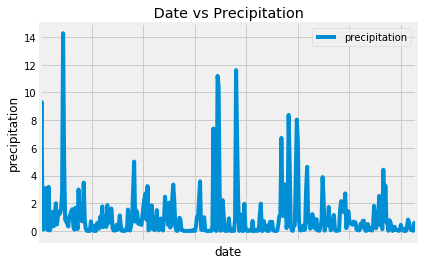

In [56]:
# Sort the dataframe by date

date_precip_grouped_df_for_1_year.plot(x="date",y="precipitation",kind="line",title=" Date vs Precipitation ")
plt.tick_params(
   axis='x',          # changes apply to the x-axis
   which='both',      # both major and minor ticks are affected
   bottom=False,      # ticks along the bottom edge are off
   top=False,         # ticks along the top edge are off
   labelbottom=False)

plt.ylabel("precipitation")

In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_grouped_df_for_1_year.describe()

,precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


### Explanation of my approach to completing the second section

* Now, we are interested in different information. I used SQL Alchemy queries to find out how many stations are in the Station datatable, and how active each station is (from how many rows are provided for each station). I filtered the dataset, only considering the most active station, and then I went through the same process as before to create two separate lists (via a for-loop), a dictionary, and then a dataframe I could use to plot the results.

In [66]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(func.count(Station.station)).all()
print(f"There are {station_count} stations in this dataset")

There are [(9,)] stations in this dataset


In [68]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_counts_list_desc = session.query(Measurement.station, func.count(Measurement.station).label("scount")).\
                    group_by(Measurement.station).\
                    order_by(desc("scount")).\
                    all()

print(station_counts_list_desc)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station_temperatures = session.query(Measurement.station, func.min(Measurement.tobs),\
                        func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                        filter(Measurement.station == 'USC00519281').\
                        all()
print(most_active_station_temperatures)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


In [70]:
# Choose the station with the highest number of temperature observations. (USC00519281)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_temperature_observations_from_last_year = session.query(Measurement.station, Measurement.tobs).\
                        filter(Measurement.station == 'USC00519281').\
                        filter(Measurement.date >= prev_year_date).all()

print(most_active_station_temperature_observations_from_last_year)


[('USC00519281', 77.0), ('USC00519281', 77.0), ('USC00519281', 80.0), ('USC00519281', 80.0), ('USC00519281', 75.0), ('USC00519281', 73.0), ('USC00519281', 78.0), ('USC00519281', 77.0), ('USC00519281', 78.0), ('USC00519281', 80.0), ('USC00519281', 80.0), ('USC00519281', 78.0), ('USC00519281', 78.0), ('USC00519281', 78.0), ('USC00519281', 73.0), ('USC00519281', 74.0), ('USC00519281', 80.0), ('USC00519281', 79.0), ('USC00519281', 77.0), ('USC00519281', 80.0), ('USC00519281', 76.0), ('USC00519281', 79.0), ('USC00519281', 75.0), ('USC00519281', 79.0), ('USC00519281', 78.0), ('USC00519281', 79.0), ('USC00519281', 78.0), ('USC00519281', 78.0), ('USC00519281', 76.0), ('USC00519281', 74.0), ('USC00519281', 77.0), ('USC00519281', 78.0), ('USC00519281', 79.0), ('USC00519281', 79.0), ('USC00519281', 77.0), ('USC00519281', 80.0), ('USC00519281', 78.0), ('USC00519281', 78.0), ('USC00519281', 78.0), ('USC00519281', 77.0), ('USC00519281', 79.0), ('USC00519281', 79.0), ('USC00519281', 79.0), ('USC00519

In [71]:
station_list1=list()
tobs_list1=list()
cnt=0
for row in result5:
    cnt+=1
    station_list1.append(row.station)
    tobs_list1.append(row.tobs)
    if cnt % 100 == 0 :
        print(row.station, row.tobs)

USC00519281 73.0
USC00519281 66.0
USC00519281 75.0


In [24]:
tobs_data_dict={"station":station_lst1,"tobs":tobs_lst1}
type(tobs_data_dict)

dict

In [25]:
df_4 = pd.DataFrame(tobs_data_dict)
df_4.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


Text(0.5, 0, 'Temperature (in ºF)')

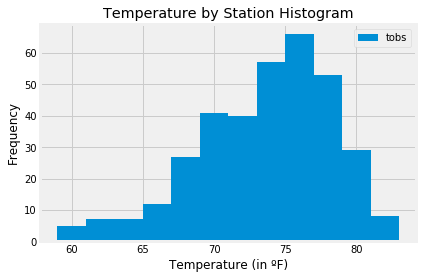

In [29]:
df_4.plot(kind="hist", bins = 12)
plt.title("Temperature by Station Histogram")
plt.xlabel("Temperature (in ºF)")